In [1]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.merge import _Merge

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.initializers import RandomNormal

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from functools import partial

from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [2]:
class RandomWeightedAverage(_Merge):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
    """Provides a (random) weighted average between real and generated image samples"""

    def _merge_function(self, inputs):
        alpha = K.random_uniform((self.batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])


In [3]:
class GAN():

    def __init__(self
        , input_dim
        , discriminator_conv_filters
        , discriminator_conv_kernel_size
        , discriminator_conv_strides
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , z_dim
        , batch_size
        ):

        self.input_dim = input_dim
        self.discriminator_conv_filters = discriminator_conv_filters
        self.discriminator_conv_kernel_size = discriminator_conv_kernel_size
        self.discriminator_conv_strides = discriminator_conv_strides

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides

        self.z_dim = z_dim
        self.n_layers_discriminator = len(discriminator_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)
        self.batch_size = batch_size 
        self.weight_init = RandomNormal(mean = 0 ,stddev=0.02)

        self.weight_save_dir ="./weight_wgan/"
        ##Initialize parameter

        self._build()

    def wasserstein(self, y_true, y_pred):
        return -K.mean(y_true * y_pred)

    def gradient_penalty_loss(self, y_true, y_pred, samples, sample_weight=None):
        gradients = K.gradients(y_pred, samples)[0]
        gradient_l2_norm = K.sqrt(
            K.sum(
                K.square(gradients),
                axis=list(range(1, len(gradients.shape))
                          )
            )
        )
        return K.mean(K.square(1 - gradient_l2_norm))

    def discriminator_model(self):
        discriminator_input = Input(shape=self.input_dim)
        x =discriminator_input

        for i in range(self.n_layers_discriminator):
            conv_layer = Conv2D(
                filters= self.discriminator_conv_filters[i],
                kernel_size = self.discriminator_conv_kernel_size[i],
                strides = self.discriminator_conv_strides[i],
                padding = 'same',
                kernel_initializer= self.weight_init 
            )
            x = conv_layer(x)
            x = Activation('relu')(x)
            x = Dropout(rate=0.4)(x)

        x = Flatten()(x)
        discriminator_output = Dense(1,activation=None,kernel_initializer=self.weight_init)(x)

        self.discriminator = Model(discriminator_input,discriminator_output)

        ## discriminator

    def generator_model(self):
        generator_input = Input(shape=(self.z_dim,))
        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Reshape(self.generator_initial_dense_layer_size)(x)
        x = Dropout(rate=0.4)(x)

        for i in range(self.n_layers_generator):
            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                conv_layer = Conv2D(
                    filters = self.generator_conv_filters[i],
                    kernel_size = self.generator_conv_kernel_size[i],
                    padding = 'same'
                )
                x = conv_layer(x)
            else:
                conv_layer = Conv2DTranspose(
                    filters = self.generator_conv_filters[i],
                    kernel_size = self.generator_conv_kernel_size[i],
                    strides = self.generator_conv_strides[i],
                    padding = 'same'
                )
                x = conv_layer(x)
            if i < self.n_layers_generator -1:
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
            else:
                x = Activation('tanh')(x)
        
        generator_output = x
        self.generator = Model(generator_input,generator_output)

    def critic_model(self):
        real_img = Input(shape=self.input_dim)
        z_disc = Input(shape =(self.z_dim, ))
        fake_img = self.generator(z_disc)
        fake = self.discriminator(fake_img)
        valid = self.discriminator(real_img)
        # fake = fake_image's discriminator value
        # valid = real_image's discriminator value

        interpolated_img = RandomWeightedAverage(self.batch_size)([real_img,fake_img])
        validity_interpolated =self.discriminator(interpolated_img)
        # validity_interpolated = interpolate's image discimiator value
        self.gp_loss = partial(self.gradient_penalty_loss, samples = interpolated_img)
        
        self.critic = Model(inputs=[real_img, z_disc], outputs=[
                                  valid, fake, validity_interpolated])

    def generator_discrimin_model(self):
        model_input = Input(shape=(self.z_dim,))
        model_output = self.discriminator(self.generator(model_input))
        self.generator_discrimin = Model(model_input,model_output)
        # In this model = Random noise -> generate -> discriminate 
        # Mean : generator's fake image discriminating
     
    def generator_compile(self):
        self.generator.compile(
            optimizer=RMSprop(lr=0.0008),
            loss=self.wasserstein
        )
        # Don't Used

    def critic_compile(self):
        self.generator.trainable = False
        self.discriminator.trainable = True
        # In Critic, generator not train, Only discriminator train
        # gp in partial function in critic model
        self.critic.compile(
            loss=[self.wasserstein, self.wasserstein, self.gp_loss],
            optimizer=Adam(lr=0.0008, beta_1=0.5),
            loss_weights=[1, 1, 10]
        )
        # critic have 3 output, valid,fake,interpolate,
        # interpolate image nedd gp loss, loss_weight = 10

    def generator_discrimin_compile(self):
        self.discriminator.trainable = False
        self.generator.trainable = True
        # model for generator, so discriminator training = False
        self.generator_discrimin.compile(
            optimizer=RMSprop(lr=0.0004),
            loss=self.wasserstein,
            metrics=['accuracy']
        )

    def critic_train(self,x_train,batch_size):
        valid = np.ones((batch_size, 1), dtype=np.float32)
        fake = -np.ones((batch_size,1), dtype=np.float32)
        dummy = np.zeros((batch_size, 1), dtype=np.float32)

        idx = np.random.randint(0, x_train.shape[0], batch_size)
        true_image = x_train[idx]

        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.critic.train_on_batch([true_image,noise],[valid,fake,dummy])

    def generator_train(self,batch_size):
        valid = np.ones((batch_size, 1), dtype=np.float32)
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.generator_discrimin.train_on_batch(noise, valid)
        # In model to 1(generator train)

    def train(self,x_train,epoch):
        for i in range(epoch):
            for _ in range(5):
                d_loss = self.critic_train(x_train, self.batch_size)

                ## train critic
            g_loss = self.generator_train(self.batch_size)
            ## train generator
            print(i, end=" ")
        
    
            if i%100 == 0:
                show_random_image(self)
                self.save_weight()
                print(i,d_loss,g_loss)
        return (i,d_loss,g_loss)

    def _build(self):
        self.discriminator_model()
        self.generator_model()
        self.critic_model()
        self.generator_discrimin_model()

        self.critic_compile()
        self.generator_discrimin_compile()

    def save_weight(self):
        self.generator_discrimin.save_weights(self.weight_save_dir + "generator.h5")
        self.critic.save_weights(self.weight_save_dir + "critic.h5")
        print("weight save")

    def load_weight(self):
        try:
            self.generator_discrimin.load_weights(self.weight_save_dir + "generator.h5")
            self.critic.load_weights(self.weight_save_dir + "critic.h5")
            
        except:
            self.save_weight()
            self.load_weight()

        print("weight loaded")


In [4]:
gan = GAN(input_dim = (64,64,3)
        , discriminator_conv_filters = [64,128,256,512]
        , discriminator_conv_kernel_size = [5,5,5,5]
        , discriminator_conv_strides = [2,2,2,2]
        , generator_initial_dense_layer_size = (4, 4, 512)
        , generator_upsample = [1,1, 1, 1]
        , generator_conv_filters = [256,128, 64,3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2,2, 2, 2]
        , z_dim = 100
        , batch_size = 64
        )


In [5]:
data = None

def camel_data():
    data = np.load("/home/sjo506/Gan_practice/test/camel/camel.npy")
    data = data/255.0
    data = np.reshape(data,(len(data),28,28,1))
    return data

def caleba_data():
    DATA_PATH = '/home/sjo506/Gan_practice/test/celeba'
    BATCH_SIZE = 64*4
    data_gen = ImageDataGenerator(rescale=1./255) 
    data_flow = data_gen.flow_from_directory(DATA_PATH,
    target_size = [64,64],
    batch_size = BATCH_SIZE,
    shuffle= True,
    class_mode='input',
    subset='training'
        )
    return data_flow

def show_random_image(trainer):
    znew = np.random.normal(0, 1, size=(1, gan.z_dim))
    znew_img = trainer.generator.predict(znew)[0]
    znew_img = np.clip((0.5*(znew_img+1)),0,1)
    plt.imshow(znew_img)
    plt.show()

data = caleba_data()


Found 202599 images belonging to 1 classes.


weight loaded


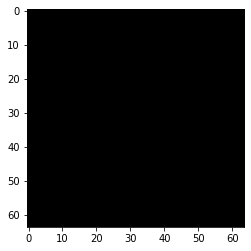

/home/sjo506/.local/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/sjo506/.local/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 

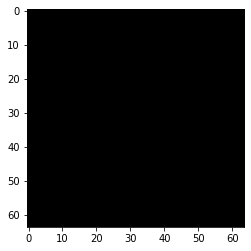

weight save
0 [nan, nan, nan, nan] [nan, 0.0]


/home/sjo506/.local/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

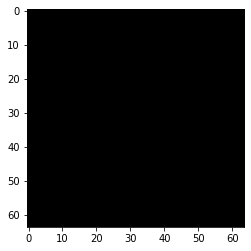

weight save
100 [nan, nan, nan, nan] [nan, 0.0]


KeyboardInterrupt: 

In [6]:
gan.load_weight()
#for data_g in data:
train,label = next(data)
show_random_image(gan)
loss = gan.train(train,1000)
print(loss)

In [ ]:
show_random_image(gan)
loss = gan.train(train,1000)
print(loss)